### Try non linear models like Decision Tree or Random Forest and Gradient Boosting

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from load_dfs import load_openmeteo, load_spotprices, load_consumption

# Load the weather and spot prices data
AarhusWeatherdf = load_openmeteo()
spot_prices = load_spotprices()
consumption = load_consumption()

# Assuming both dataframes have a datetime index or a common column to merge on
merged_data = pd.merge(AarhusWeatherdf, spot_prices, left_on='time',right_on='HourDK')
merged_data = pd.merge(merged_data, consumption, left_on='time',right_on='HourDK')
merged_data['hour_of_day'] = merged_data['time'].dt.hour


In [2]:
# Select the input variables and the target variable
X = merged_data[['wind_speed_10m (km/h)', 'terrestrial_radiation (W/m²)', 'ShareMWh', 'hour_of_day']]
y = merged_data['SpotPriceEUR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [3]:
# Create and train the decision tree model
randforest = RandomForestRegressor(random_state=42)
randforest.fit(X_train, y_train)

# Make predictions on the test set
y_pred_randforest = randforest.predict(X_test)

# Evaluate the model
mse_randforest = mean_squared_error(y_test, y_pred_randforest)
r2_randforest = r2_score(y_test, y_pred_randforest)

print(f"Mean Squared Error: {mse_randforest}")
print(f"R^2 Score: {r2_randforest}")

Mean Squared Error: 1247.9141640063256
R^2 Score: 0.4539565440443565


In [22]:
import matplotlib.pyplot as plt

def plot_y_pred_vs_y_test(y_test,y_pred, xlim=250):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Values', marker='o')
    plt.plot(y_pred_randforest, label='Predicted Values', marker='x')
    plt.xlabel('Sample Index')
    plt.ylabel('SpotPriceEUR')
    plt.title('Actual vs Predicted SpotPriceEUR')
    plt.xlim(0,xlim)
    plt.legend()
    plt.show()

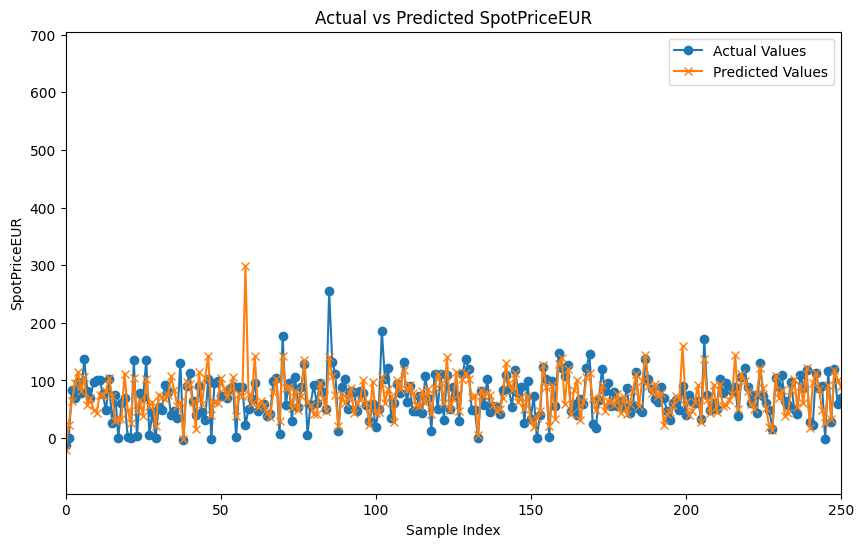

In [5]:
# Plot the actual vs predicted values

plot_y_pred_vs_y_test(y_test,y_pred_randforest)

In [6]:
# Random Forest has the lowest MSE and highest R^2 score so far 
# (DecisionTreeRegressor was worse than linear model in linear_regression.py)

## Gradient Boost

In [7]:
# Create and train the decision tree model
gradboost = GradientBoostingRegressor(random_state=42)
gradboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gradboost = gradboost.predict(X_test)

# Evaluate the model
mse_gradboost = mean_squared_error(y_test, y_pred_gradboost)
r2_gradboost = r2_score(y_test, y_pred_gradboost)

print(f"Mean Squared Error: {mse_gradboost}")
print(f"R^2 Score: {r2_gradboost}")


Mean Squared Error: 1236.799034206434
R^2 Score: 0.4588201348780747


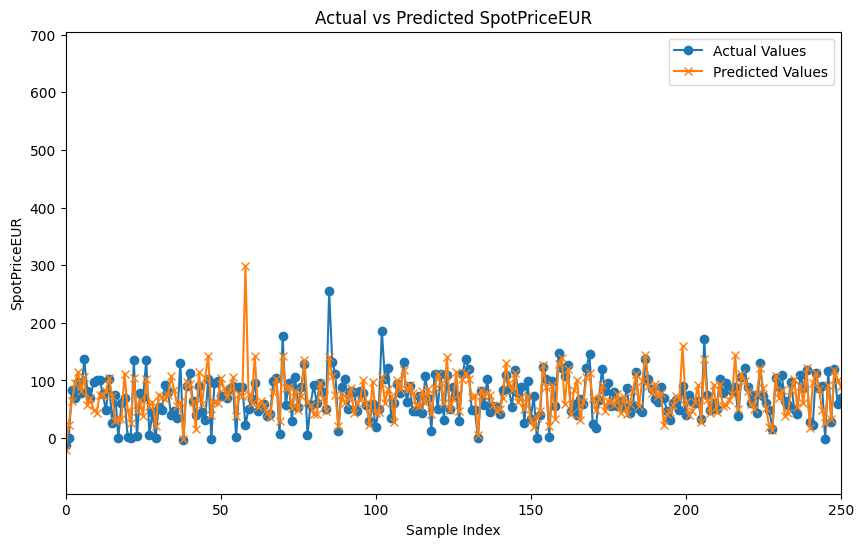

In [8]:
# Plot the actual vs predicted values
plot_y_pred_vs_y_test(y_test,y_pred_gradboost)

## HistGradientBoost

In [9]:
# Create and train the Histogram-based Gradient Boosting model
histgradboost = HistGradientBoostingRegressor(random_state=42)
histgradboost.fit(X_train, y_train)

# Make predictions on the test set
y_pred_histgradboost = histgradboost.predict(X_test)
y_pred = histgradboost.predict(X_test)

# Evaluate the model
mse_histgradboost = mean_squared_error(y_test, y_pred_histgradboost)
r2_histgradboost = r2_score(y_test, y_pred_histgradboost)

print(f"Mean Squared Error: {mse_histgradboost}")
print(f"R^2 Score: {r2_histgradboost}")

Mean Squared Error: 1203.0651744595195
R^2 Score: 0.4735808883739656


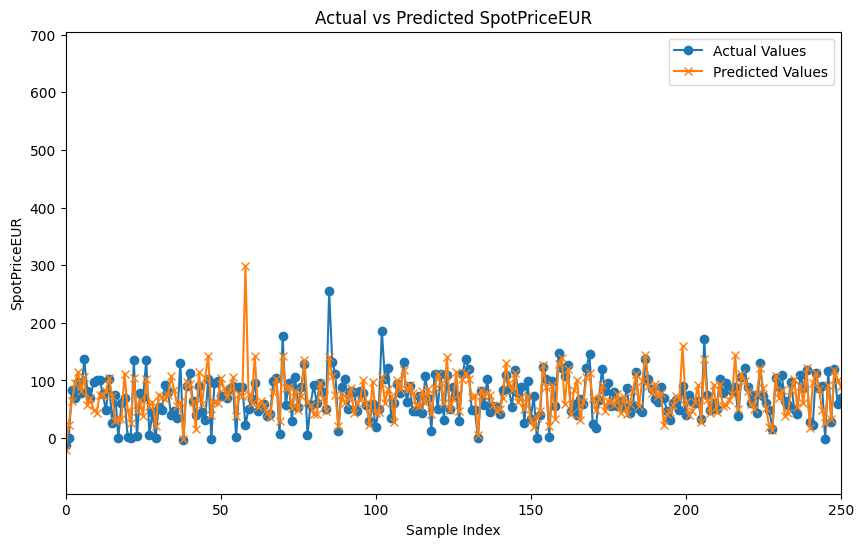

In [10]:
plot_y_pred_vs_y_test(y_test,y_pred_histgradboost)

In [18]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.15,0.2,0.25],
    'max_iter': [100, 150, 200],
    'max_depth': [3, 5, 7, 9],
    'min_samples_leaf': [1, 5, 10],
    'max_bins': [8,24,48,64],
    'l2_regularization': [0.5, 1.0],
    'max_leaf_nodes': [10],
}

# Create the Grid Search object
grid_search = GridSearchCV(HistGradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Optimized Mean Squared Error: {mse_best}")
print(f"Optimized R^2 Score: {r2_best}")

Best Parameters: {'l2_regularization': 1.0, 'learning_rate': 0.2, 'max_bins': 64, 'max_depth': 7, 'max_iter': 150, 'max_leaf_nodes': 10, 'min_samples_leaf': 5}
Optimized Mean Squared Error: 1127.8577611357646
Optimized R^2 Score: 0.5064890138438674


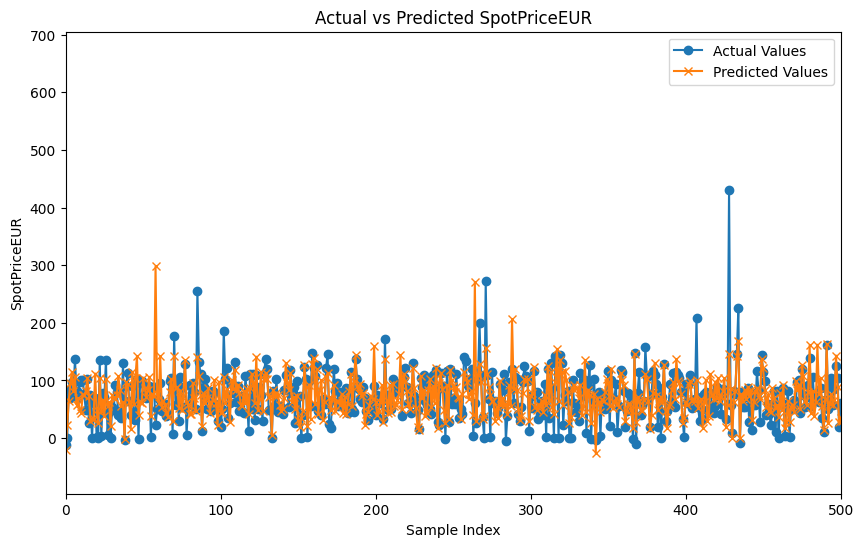

In [23]:
plot_y_pred_vs_y_test(y_test,y_pred_best, xlim=500)

In [13]:
#r2 of 0.5 means that 50% of the variability cannot be explained by the model
#so it's still a crappy model
#but it's better than the previous ones
#can try other models or feature engineering

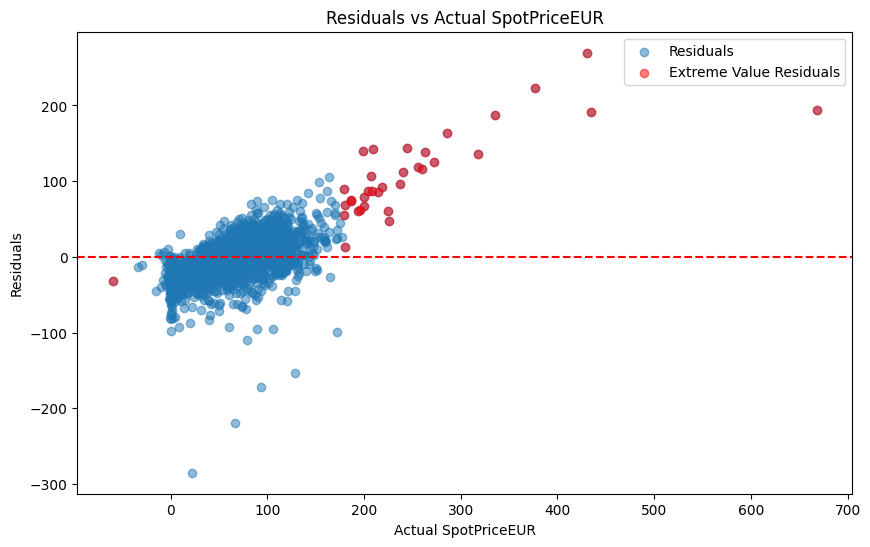

Extreme Values Mean Squared Error: 15161.665002015789
Non-Extreme Values Mean Squared Error: 850.4452924206943
Extreme Values R^2 Score: -0.22601898272442145
Non-Extreme Values R^2 Score: 0.42371765575053943


In [26]:
# Identify extreme values in the test set (e.g., values beyond 1.5 times the interquartile range)
q1 = y_test.quantile(0.25)
q3 = y_test.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Calculate residuals
residuals = y_test - y_pred_best

extreme_values = y_test[(y_test < lower_bound) | (y_test > upper_bound)]
extreme_indices = extreme_values.index
extreme_residuals = residuals.loc[extreme_indices]

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, label='Residuals',alpha=0.5)
plt.scatter(extreme_values, extreme_residuals, color='red', label='Extreme Value Residuals',alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual SpotPriceEUR')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual SpotPriceEUR')
plt.legend()
plt.show()

# Calculate MSE for extreme values and non-extreme values
extreme_y_pred = y_pred_best[np.isin(X_test.index, extreme_indices)]
extreme_mse = mean_squared_error(extreme_values, extreme_y_pred)
extreme_r2 = r2_score(extreme_values, extreme_y_pred)

non_extreme_values = y_test.drop(extreme_values.index)
non_extreme_pred = y_pred_best[np.isin(y_test.index, non_extreme_values.index)]
non_extreme_mse = mean_squared_error(non_extreme_values, non_extreme_pred)
non_extreme_r2 = r2_score(non_extreme_values, non_extreme_pred)

print(f"Extreme Values Mean Squared Error: {extreme_mse}")
print(f"Non-Extreme Values Mean Squared Error: {non_extreme_mse}")

print(f"Extreme Values R^2 Score: {extreme_r2}")
print(f"Non-Extreme Values R^2 Score: {non_extreme_r2}")